This is the code for the DiD but with recession and age group

Source of code from the data file used below is from the original authors stata code.

https://www.openicpsr.org/openicpsr/project/113484/version/V1/view?path=/openicpsr/113484/fcr:versions/V1/P2016_1118_data&type=folder

In [1]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())
print(df.head())

/Users/rebeccluo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/rebeccluo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [2]:
print(df.columns.tolist())

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [3]:
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in

df.set_index(['sippid', 'months'], inplace=True)

In [4]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(df['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(df[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(df['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    age_group_dummies = pd.get_dummies(df['age_group'], drop_first=True)  # Dummies for age groups
    recession_dummies = pd.get_dummies(df['recession_birth'], drop_first=True)  # Dummies for recession years

    
    age_recession_interactions = pd.DataFrame(index=df.index)
    for age_col in age_group_dummies.columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{age_col}_recession_{recession_col}'
            age_recession_interactions[interaction_name] = age_group_dummies[age_col] * recession_dummies[recession_col]
    
    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=df.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=df.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]



    state_year_interactions = pd.DataFrame(index=df.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]


    llbipos_interactions_recession = pd.DataFrame(index=df.index)
    for var in df[llbipos_vars].columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{var}_recession_{recession_col}'
            llbipos_interactions_recession[interaction_name] = df[var] * recession_dummies[recession_col]

    llbipos_interactions_age = pd.DataFrame(index=df.index)
    for var in df[llbipos_vars].columns:
        for age_col in age_group_dummies.columns:
            interaction_name = f'{var}_age_{age_col}'
            llbipos_interactions_age[interaction_name] = df[var] * age_group_dummies[age_col]

    # Step 8: Create interaction terms for llbipos_vars with both recession and age group
    llbipos_interactions_combined = pd.DataFrame(index=df.index)
    for var in df[llbipos_vars].columns:
        for recession_col in recession_dummies.columns:
            for age_col in age_group_dummies.columns:
                interaction_name = f'{var}_recession_{recession_col}_age_{age_col}'
                llbipos_interactions_combined[interaction_name] = df[var] * recession_dummies[recession_col] * age_group_dummies[age_col]


In [5]:
#Combine all dummies and interaction terms into a final DataFrame
X = pd.concat([age_group_dummies,recession_dummies,year_dummies,age_recession_interactions, state_year_interactions,birth_dummies, birth_time_interactions, birth_state_interactions, llbipos_interactions_recession, llbipos_interactions_age, llbipos_interactions_combined, df[llbipos_vars]], axis=1)




# Step 5: Add constant term for the regression
X = sm.add_constant(X)

# Step 6: Define the dependent variable (y)
y = df["rm_lfp"]  # Assuming 'rm_lfp' is your dependent variable for labor force participation

In [6]:

model = PanelOLS(y, X, entity_effects=True, time_effects=True,weights=df['end_weight'],drop_absorbed=True,check_rank=False)
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)
latex_output = results.summary.as_latex()
print(latex_output)

/Users/rebeccluo/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1573/822696194.py:2: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

1.0, 2012, _IBirth_2_time_1999, _IBirth_2_time_2002, _IBirth_2_time_2006, _IBirth_2_time_2007, _IBirth_2_time_2011, _IBirth_2_time_2012, _IBirth_3_time_1999, _LlBiXpos_2_1_recession_1.0, _IBirth_3_time_2007, _IBirth_3_time_2011, _IBirth_3_time_2012, _IBirth_4_time_1999, _IBirth_4_time_2007, _IBirth_4_time_2011, _IBirth_4_time_2012, _IBirth_5_time_1999, _IBirth_5_time_2007, _IBirth_5_time_2011, _IBirth_5_time_2012, _IBirth_6_time_1999, _IBirth_6_time_2007, _IBirth_6_time_2011, _IBirth_6_time_2012, _IBirth_7_time_1999, _IBirth_7_time_2007, _IBirth_7_time

                          PanelOLS Estimation Summary                           
Dep. Variable:                 rm_lfp   R-squared:                        0.0616
Estimator:                   PanelOLS   R-squared (Between):             -0.1075
No. Observations:              103608   R-squared (Within):               0.0616
Date:                Sun, Oct 20 2024   R-squared (Overall):             -0.0490
Time:                        02:07:51   Log-likelihood                -1.215e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.637
Entities:                        2817   P-value                           0.0000
Avg Obs:                       36.780   Distribution:              F(1285,99459)
Min Obs:                       2.0000                                           
Max Obs:                       48.000   F-statistic (robust):             1559.1
                            

In [7]:
#RECESSION SIGNIFICANCE ON LFP

from scipy.stats import chi2
test_vars = ['_LlBiXpos_14_1_recession_1.0', 
             '_LlBiXpos_15_1_recession_1.0','_LlBiXpos_16_1_recession_1.0','_LlBiXpos_17_1_recession_1.0','_LlBiXpos_18_1_recession_1.0','_LlBiXpos_19_1_recession_1.0','_LlBiXpos_20_1_recession_1.0','_LlBiXpos_21_1_recession_1.0']
# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -11 to -4:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -11 to -4:
Wald Test Statistic: 7.867626051790244
p-value: 0.4465066249327192


In [8]:
test_vars = ['_LlBiXpos_23_1_recession_1.0', '_LlBiXpos_24_1_recession_1.0', 
             '_LlBiXpos_25_1_recession_1.0','_LlBiXpos_26_1_recession_1.0','_LlBiXpos_27_1_recession_1.0','_LlBiXpos_28_1_recession_1.0','_LlBiXpos_29_1_recession_1.0']
# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -2 to 4:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -2 to 4:
Wald Test Statistic: 12.258196699104328
p-value: 0.09238129941846651


In [9]:
test_vars = ['_LlBiXpos_21_1_recession_1.0', '_LlBiXpos_22_1_recession_1.0', 
             '_LlBiXpos_23_1_recession_1.0','_LlBiXpos_24_1_recession_1.0','_LlBiXpos_25_1_recession_1.0','_LlBiXpos_26_1_recession_1.0']
# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -4 to 1:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -4 to 1:
Wald Test Statistic: 9.329787857354091
p-value: 0.1558628125523921


In [10]:
from scipy.stats import chi2
test_vars = ['_LlBiXpos_22_1_recession_1.0_age_30s', '_LlBiXpos_23_1_recession_1.0_age_30s', '_LlBiXpos_24_1_recession_1.0_age_30s', 
             '_LlBiXpos_25_1_recession_1.0_age_30s', '_LlBiXpos_26_1_recession_1.0_age_30s', '_LlBiXpos_27_1_recession_1.0_age_30s', 
             '_LlBiXpos_28_1_recession_1.0_age_30s']

# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -3 to +3:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -3 to +3:
Wald Test Statistic: 7.174355992569225
p-value: 0.41095472266400657


In [11]:
from scipy.stats import chi2
test_vars = ['_LlBiXpos_22_1_age_30s', '_LlBiXpos_23_1_age_30s', '_LlBiXpos_24_1_age_30s', 
             '_LlBiXpos_25_1_age_30s', '_LlBiXpos_26_1_age_30s', '_LlBiXpos_27_1_age_30s', 
             '_LlBiXpos_28_1_age_30s']

# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -3 to +3:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -3 to +3:
Wald Test Statistic: 12.15187327435638
p-value: 0.09567375596069216


F-test for age -10 to -3

In [12]:
from scipy.stats import chi2
test_vars = ['_LlBiXpos_15_1_age_40s', '_LlBiXpos_16_1_age_40s', '_LlBiXpos_17_1_age_40s', 
             '_LlBiXpos_18_1_age_40s', '_LlBiXpos_19_1_age_40s', '_LlBiXpos_20_1_age_40s', 
             '_LlBiXpos_21_1_age_40s','_LlBiXpos_22_1_age_40s']

# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -10 to -3:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -10 to -3:
Wald Test Statistic: 14.07622356439013
p-value: 0.07980018398492528


In [13]:
from scipy.stats import chi2
test_vars = ['_LlBiXpos_15_1_age_30s', '_LlBiXpos_16_1_age_30s', '_LlBiXpos_17_1_age_30s', 
             '_LlBiXpos_18_1_age_30s', '_LlBiXpos_19_1_age_30s', '_LlBiXpos_20_1_age_30s', 
             '_LlBiXpos_21_1_age_30s','_LlBiXpos_22_1_age_30s']

# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -10 to -3:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -10 to -3:
Wald Test Statistic: 7.304001241972466
p-value: 0.5042164530960126


In [14]:
#BASE effect of birth with policy (no interaction)
b_X6 = pd.Series(index=range(1, 50), dtype=float)

for j in range(1, 50):
    if 1 <= j <= 7:
        b_X6[j] = 0  # Set to 0 for indices 1 to 7
    else:
        var_name = f'_LlBiXpos_{j}_1'  # Name of the variable corresponding to the coefficient
        if var_name in results.params:  # Check if this variable was in the regression model
            b_X6[j] = results.params[var_name]  # Assign the coefficient from the regression
        else:
            b_X6[j] = None  # Handle the case where the variable might not be in the results

# Create the time column with values from -24 to 24
time_column = list(range(-24, 25))

# Create a DataFrame with the time column and b_X3
b_X6_df = pd.DataFrame({
    'time': time_column,
    'b_X6': b_X6
})

# Print the DataFrame
print(b_X6_df) #creating and storing the event-study DiD estimates


    time      b_X6
1    -24  0.000000
2    -23  0.000000
3    -22  0.000000
4    -21  0.000000
5    -20  0.000000
6    -19  0.000000
7    -18  0.000000
8    -17  0.003212
9    -16  0.054755
10   -15  0.052669
11   -14  0.048596
12   -13  0.010071
13   -12  0.068196
14   -11  0.029335
15   -10  0.022968
16    -9 -0.004912
17    -8 -0.038783
18    -7 -0.029038
19    -6 -0.007869
20    -5  0.023242
21    -4 -0.003715
22    -3  0.027473
23    -2  0.046082
24    -1  0.014519
25     0  0.059888
26     1  0.025019
27     2 -0.055194
28     3 -0.083770
29     4 -0.000086
30     5 -0.024011
31     6 -0.034898
32     7 -0.005461
33     8 -0.098448
34     9 -0.061171
35    10 -0.038470
36    11 -0.077051
37    12 -0.007691
38    13 -0.018986
39    14 -0.032142
40    15  0.024625
41    16  0.012274
42    17  0.040740
43    18  0.064279
44    19  0.043061
45    20  0.102313
46    21  0.061251
47    22  0.031677
48    23  0.066714
49    24  0.062280


In [15]:
#With Recession
# Now do the same for b_X6 if needed
b_X7 = pd.Series(index=range(1, 50), dtype=float)

for j in range(1, 50):
    if 1 <= j <= 7:
        b_X7[j] = 0  # Set to 0 for indices 1 to 7
    else:
        var_name = f'_LlBiXpos_{j}_1_recession_1.0'  # Name of the variable corresponding to the coefficient
        if var_name in results.params:  # Check if this variable was in the regression model
            b_X7[j] = results.params[var_name]  # Assign the coefficient from the regression
        else:
            b_X7[j] = None  # Handle the case where the variable might not be in the results

# Create the time column with values from -24 to 24
time_column = list(range(-24, 25))

# Create a DataFrame with the time column and b_X3
b_X7_df = pd.DataFrame({
    'time': time_column,
    'b_X7': b_X7
})

# Print the DataFrame
print(b_X7_df) #creating and storing the event-study DiD estimates


    time      b_X7
1    -24  0.000000
2    -23  0.000000
3    -22  0.000000
4    -21  0.000000
5    -20  0.000000
6    -19  0.000000
7    -18  0.000000
8    -17  0.113476
9    -16 -0.093864
10   -15 -0.116912
11   -14 -0.132362
12   -13 -0.268907
13   -12 -0.304226
14   -11 -0.322466
15   -10 -0.201670
16    -9 -0.159211
17    -8 -0.133422
18    -7 -0.098254
19    -6 -0.069581
20    -5 -0.067066
21    -4 -0.052648
22    -3 -0.124958
23    -2 -0.222570
24    -1 -0.202288
25     0 -0.200145
26     1 -0.141220
27     2 -0.072464
28     3 -0.006676
29     4 -0.095765
30     5 -0.055779
31     6 -0.104590
32     7 -0.120998
33     8 -0.052283
34     9 -0.119192
35    10 -0.093300
36    11 -0.157692
37    12 -0.184003
38    13 -0.146111
39    14 -0.088000
40    15 -0.164271
41    16 -0.273606
42    17 -0.288307
43    18 -0.405368
44    19 -0.416768
45    20 -0.459935
46    21 -0.419499
47    22 -0.350705
48    23 -0.368421
49    24 -0.385736


In [16]:
#AGE WITH RECESSION ESTIMATES

b_X7_30s = pd.Series(index=range(1, 50), dtype=float)
b_X7_40s = pd.Series(index=range(1, 50), dtype=float)

# Loop through the indices to assign coefficients for the 30s
for j in range(1, 50):
    if 1 <= j <= 7:
        b_X7_30s[j] = 0  # Set to 0 for indices 1 to 7 for 30s
    else:
        var_name_30s = f'_LlBiXpos_{j}_1_recession_1.0_age_30s'  # Variable name for age group 30s
        if var_name_30s in results.params:  # Check if this variable was in the regression model
            b_X7_30s[j] = results.params[var_name_30s]  # Assign the coefficient
        else:
            b_X7_30s[j] = None  # Handle missing variable

# Loop through the indices to assign coefficients for the 40s
for j in range(1, 50):
    if 1 <= j <= 7:
        b_X7_40s[j] = 0  # Set to 0 for indices 1 to 7 for 40s
    else:
        var_name_40s = f'_LlBiXpos_{j}_1_recession_1.0_age_40s'  # Variable name for age group 40s
        if var_name_40s in results.params:  # Check if this variable was in the regression model
            b_X7_40s[j] = results.params[var_name_40s]  # Assign the coefficient
        else:
            b_X7_40s[j] = None  # Handle missing variable
            
print(b_X7_30s)
print(b_X7_40s)

1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8    -0.156987
9     0.053700
10    0.038043
11   -0.000303
12    0.051763
13    0.016544
14   -0.008311
15   -0.100948
16   -0.161877
17   -0.184958
18   -0.173287
19   -0.206597
20   -0.166275
21   -0.187143
22   -0.139289
23   -0.054301
24   -0.071262
25   -0.026615
26   -0.072845
27   -0.134783
28   -0.148503
29   -0.057832
30   -0.121587
31   -0.095303
32   -0.099703
33   -0.169244
34   -0.101508
35   -0.116760
36   -0.021728
37    0.005251
38   -0.037680
39   -0.079087
40   -0.027755
41    0.121307
42    0.150470
43    0.268419
44    0.260115
45    0.260619
46    0.229287
47    0.167376
48    0.242631
49    0.251778
dtype: float64
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17        

In [17]:
#ES DD FOR AGE

b_X8_30s = pd.Series(index=range(1, 50), dtype=float)
b_X8_40s = pd.Series(index=range(1, 50), dtype=float)

# Loop through the indices to assign coefficients for the 30s
for j in range(1, 50):
    if 1 <= j <= 7:
        b_X8_30s[j] = 0  # Set to 0 for indices 1 to 7 for 30s
    else:
        var_name_30s = f'_LlBiXpos_{j}_1_age_30s'  # Variable name for age group 30s
        if var_name_30s in results.params:  # Check if this variable was in the regression model
            b_X8_30s[j] = results.params[var_name_30s]  # Assign the coefficient
        else:
            b_X8_30s[j] = None  # Handle missing variable

# Loop through the indices to assign coefficients for the 40s
for j in range(1, 50):
    if 1 <= j <= 7:
        b_X8_40s[j] = 0  # Set to 0 for indices 1 to 7 for 40s
    else:
        var_name_40s = f'_LlBiXpos_{j}_1_age_40s'  # Variable name for age group 40s
        if var_name_40s in results.params:  # Check if this variable was in the regression model
            b_X8_40s[j] = results.params[var_name_40s]  # Assign the coefficient
        else:
            b_X8_40s[j] = None  # Handle missing variable
            
print(b_X8_30s)
print(b_X8_40s)

1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.019784
9    -0.034463
10   -0.043633
11   -0.026463
12    0.007173
13   -0.019506
14    0.012367
15    0.016057
16    0.032900
17    0.074517
18    0.082460
19    0.089946
20    0.070971
21    0.103212
22    0.114636
23    0.089896
24    0.111792
25    0.083666
26    0.090288
27    0.156933
28    0.127833
29    0.044344
30    0.070194
31    0.093701
32    0.065544
33    0.120554
34    0.084579
35    0.022834
36    0.058601
37    0.014272
38    0.033274
39    0.020872
40    0.021083
41    0.003729
42   -0.036565
43   -0.038413
44   -0.065778
45   -0.092928
46   -0.077007
47   -0.014522
48   -0.100752
49   -0.122957
dtype: float64
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.134356
9     0.163311
10    0.199980
11    0.242971
12    0.264948
13    0.169478
14    0.122120
15    0.086398
16    0.192378
17    0.24

In [18]:

# Create a DataFrame for months relative to birth
months = np.arange(-24, 25)  # From -24 to 24 months

In [19]:

# Create an empty DataFrame to store results
results_df = pd.DataFrame({
    'Month': months
})

b_X8_30s_df = pd.DataFrame({
    'Month': months,
    'Estimates_Age_30s': b_X8_30s
})

b_X8_40s_df = pd.DataFrame({
    'Month': months,
    'Estimates_Age_40s': b_X8_40s
})
comparison_df = pd.merge(results_df, b_X8_30s_df, on='Month')
comparison_df = pd.merge(comparison_df, b_X8_40s_df, on='Month')

# Final DataFrame for comparison
print("\nComparison of Estimates:")
print(comparison_df)


Comparison of Estimates:
    Month  Estimates_Age_30s  Estimates_Age_40s
0     -24           0.000000           0.000000
1     -23           0.000000           0.000000
2     -22           0.000000           0.000000
3     -21           0.000000           0.000000
4     -20           0.000000           0.000000
5     -19           0.000000           0.000000
6     -18           0.000000           0.000000
7     -17           0.019784           0.134356
8     -16          -0.034463           0.163311
9     -15          -0.043633           0.199980
10    -14          -0.026463           0.242971
11    -13           0.007173           0.264948
12    -12          -0.019506           0.169478
13    -11           0.012367           0.122120
14    -10           0.016057           0.086398
15     -9           0.032900           0.192378
16     -8           0.074517           0.241967
17     -7           0.082460           0.255824
18     -6           0.089946           0.284965
19     -5     

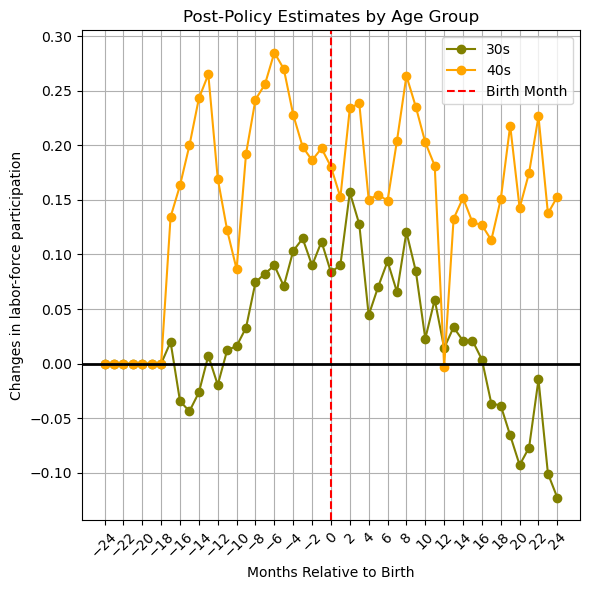

'Change in LFP is more positive for both women in their 30s and their 40s, possibly indicating that those who are older may be more tenured and thus easier\nto stay in the labour force. Despite this we see that women in their 30s become much more negative in change post birth \nthan women in their 20s where as women in their 40s retain higher lfp than women in their 20s. \nThis pattern may indicate that women in their 30s face greater challenges re-entering the workforce after childbirth compared to women in their 40s,\nwho are likely more established in their careers, and younger women, who may have more flexible employment situations or fewer caregiving responsibilities.'

In [20]:

##Graphing for age 30s and 40s

plot_df = pd.DataFrame({
    'Month': list(range(-24, 25)),
    '30s': b_X8_30s.values,
    '40s': b_X8_40s.values
})

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(plot_df['Month'], plot_df['30s'], label='30s', color='olive', marker='o')
plt.plot(plot_df['Month'], plot_df['40s'], label='40s', color='orange', marker='o')

# Adding titles and labels
plt.title('Post-Policy Estimates by Age Group')
plt.xlabel('Months Relative to Birth')
plt.ylabel('Changes in labor-force participation')
plt.axvline(0, color='red', linestyle='--', label='Birth Month')
plt.axhline(0, color='black', linestyle='-', linewidth=2)  # Add a horizontal line at y=0
plt.xticks(np.arange(-24, 25, 2),rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

'''Change in LFP is more positive for both women in their 30s and their 40s, possibly indicating that those who are older may be more tenured and thus easier
to stay in the labour force. Despite this we see that women in their 30s become much more negative in change post birth 
than women in their 20s where as women in their 40s retain higher lfp than women in their 20s. 
This pattern may indicate that women in their 30s face greater challenges re-entering the workforce after childbirth compared to women in their 40s,
who are likely more established in their careers, and younger women, who may have more flexible employment situations or fewer caregiving responsibilities.'''

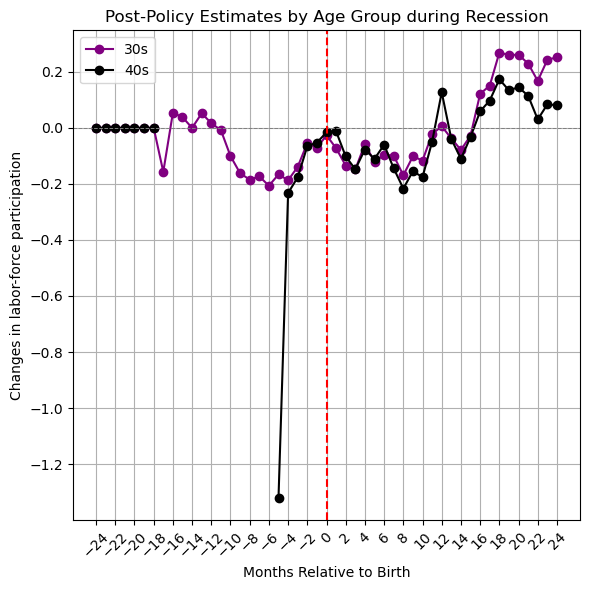

'Explanation: the 20s is the baseline, so for example a positive change in lfp by a woman in their 30s \nmeans that labor-force participation for women in their 30s is 0.2 units higher than that of women in their 20s.\n40s age group is underrepresented, better to focuse primarily on the 30s age group.\nCompared to women in their 20s, who may be more likely to be in early-career stages with less job stability, \nwomen in their 30s might have established careers, making it easier to navigate maternity leave and return to work even during recession period.\nThe observed pattern indicates that while childbirth initially disrupts labor force participation for women in their 30s more in a recession than those in their 20s, \nthey tend to rebound and possibly re-establish or even enhance their participation in the labor market after the early postpartum period.\n'

In [21]:

#AGE WITH RECESSION GRAPHING

plot_df = pd.DataFrame({
    'Month': list(range(-24, 25)),
    '30s': b_X7_30s.values,
    '40s': b_X7_40s.values
})

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(plot_df['Month'], plot_df['30s'], label='30s', color='purple', marker='o')
plt.plot(plot_df['Month'], plot_df['40s'], label='40s', color='black', marker='o')

# Adding titles and labels
plt.title('Post-Policy Estimates by Age Group during Recession')
plt.xlabel('Months Relative to Birth')
plt.ylabel('Changes in labor-force participation')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Add a horizontal line at y=0
plt.xticks(np.arange(-24, 25, 2),rotation=45)
plt.legend()
plt.axvline(0, color='red', linestyle='--', label='Birth Month')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

"""Explanation: the 20s is the baseline, so for example a positive change in lfp by a woman in their 30s 
means that labor-force participation for women in their 30s is 0.2 units higher than that of women in their 20s.
40s age group is underrepresented, better to focuse primarily on the 30s age group.
Compared to women in their 20s, who may be more likely to be in early-career stages with less job stability, 
women in their 30s might have established careers, making it easier to navigate maternity leave and return to work even during recession period.
The observed pattern indicates that while childbirth initially disrupts labor force participation for women in their 30s more in a recession than those in their 20s, 
they tend to rebound and possibly re-establish or even enhance their participation in the labor market after the early postpartum period.
"""


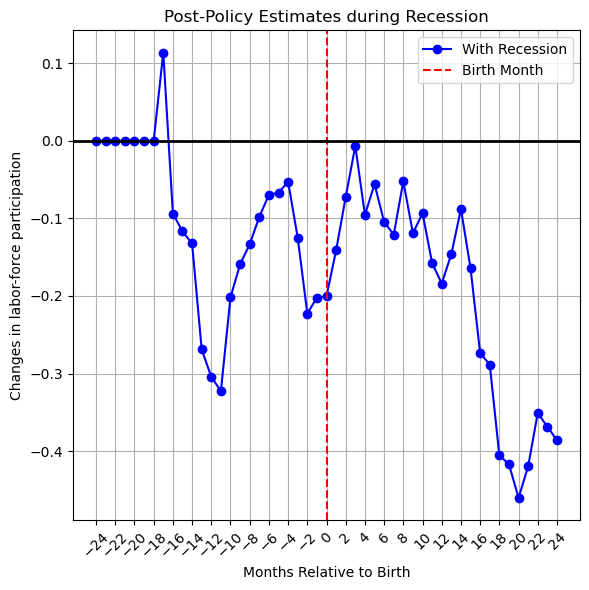

'The blue line represents the effects of birth with the post-policy implementation, \nshowing the changes in labor-force participation (LFP) attributable solely to this factor.\nEven post-policy, during a recession it is much harder for women to get back in the labour force'

In [22]:

##GRAPHING RECESSION
plot_df = pd.DataFrame({
    'Month': list(range(-24, 25)),
    'Base':b_X6.values,
    'With Recession': b_X7.values
})

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(plot_df['Month'], plot_df['With Recession'], label='With Recession', color='blue', marker='o')

# Adding titles and labels
plt.title('Post-Policy Estimates during Recession')
plt.xlabel('Months Relative to Birth')
plt.ylabel('Changes in labor-force participation')
plt.xticks(plot_df['Month'])  # Show all month labels
plt.axvline(0, color='red', linestyle='--', label='Birth Month')
plt.axhline(0, color='black', linestyle='-', linewidth=2)  # Add a horizontal line at y=0
plt.xticks(np.arange(-24, 25, 2),rotation=45)

plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

"""Explanation: If the line highlighted in yellow indicates a negative change in labor-force participation (LFP). 
This means that LFP decreases more significantly during recession years compared to periods when there is no recession."""
'''The blue line represents the effects of birth with the post-policy implementation, 
showing the changes in labor-force participation (LFP) attributable solely to this factor.
Even post-policy, during a recession it is much harder for women to get back in the labour force'''

Importing the code below used to get trends with recession effect included

In [23]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols

file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
# Load the Stata file into a DataFrame


# Display the first few rows of the DataFrame
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Include _LlBiXpos_2_1 and _LlBiXpos_8_1 to _LlBiXpos_50_1  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1

# Combine all variables into one list
state_ca = 'California'
state_nj = 'New Jersey'
df_filtered = df[(df['state'].isin([state_ca, state_nj]))]

# Define birth dummy variables
birth_vars = ' + '.join([f'_IBirth_{i}' for i in range(2, 52)])  # _IBirth_2 to _IBirth_51

formula = f'rm_lfp ~ {birth_vars}'

# Filter data for post_policy == 1 and states CA or NJ and whether or not gave birth in a recession year
df_no_policy_no_recession = df[(df['post_policy'] == 0) & 
                                ((df['state'] == state_ca) | (df['state'] == state_nj)) & 
                                (df['recession_birth'] == 0)] #no policy nor recession
df_no_policy_recession = df[(df['post_policy'] == 0) & ((df['state'] == state_ca) | (df['state'] == state_nj) & df['recession_birth']==1)] #no policy during recession
df_policy_no_recession = df[(df['post_policy'] == 1) & ((df['state'] == state_ca) | (df['state'] == state_nj) & df['recession_birth']==0)] #policy no recession
df_policy_recession = df[(df['post_policy'] == 1) & ((df['state'] == state_ca) | (df['state'] == state_nj) & df['recession_birth']==1)] #policy during recession


##Begin modelling the four cases
model_no_policy_no_recession = smf.wls(formula, data=df_no_policy_no_recession, weights=df_no_policy_no_recession['end_weight']).fit(cov_type='cluster', 
                                                                                                             cov_kwds={'groups': df_no_policy_no_recession['sippid']})


birth_coefs = model_no_policy_no_recession.params.filter(like='_IBirth_')

# Create a DataFrame for easier plotting
birth_coefs_df = pd.DataFrame(birth_coefs).reset_index()
birth_coefs_df.columns = ['Birth Variable', 'Coefficient']

# Extract birth number from the variable name for plotting
birth_coefs_df['Birth Number'] = birth_coefs_df['Birth Variable'].str.extract('(\d+)').astype(int)

# Sort the DataFrame by Birth Number
birth_coefs_df = birth_coefs_df.sort_values(by='Birth Number')

model_no_policy_recession = smf.wls(formula, data=df_no_policy_recession, weights=df_no_policy_recession['end_weight']).fit(cov_type='cluster', 
                                                                                                                            cov_kwds={'groups': df_no_policy_recession['sippid']})
birth_coefs = model_no_policy_recession.params.filter(like='_IBirth_')

# Create a DataFrame for easier plotting
birth_coefs_df = pd.DataFrame(birth_coefs).reset_index()
birth_coefs_df.columns = ['Birth Variable', 'Coefficient']

# Extract birth number from the variable name for plotting
birth_coefs_df['Birth Number'] = birth_coefs_df['Birth Variable'].str.extract('(\d+)').astype(int)

# Sort the DataFrame by Birth Number
birth_coefs_df = birth_coefs_df.sort_values(by='Birth Number')


model_policy_no_recession = smf.wls(formula, data=df_policy_no_recession, weights=df_policy_no_recession['end_weight']).fit(cov_type='cluster', 
                                                                                                             cov_kwds={'groups': df_policy_no_recession['sippid']})

birth_coefs = model_policy_no_recession.params.filter(like='_IBirth_')

# Create a DataFrame for easier plotting
birth_coefs_df = pd.DataFrame(birth_coefs).reset_index()
birth_coefs_df.columns = ['Birth Variable', 'Coefficient']

# Extract birth number from the variable name for plotting
birth_coefs_df['Birth Number'] = birth_coefs_df['Birth Variable'].str.extract('(\d+)').astype(int)

# Sort the DataFrame by Birth Number
birth_coefs_df = birth_coefs_df.sort_values(by='Birth Number')


model_policy_recession = smf.wls(formula, data=df_policy_recession, weights=df_policy_recession['end_weight']).fit(cov_type='cluster', 
                                                                                                             cov_kwds={'groups': df_policy_recession['sippid']})

birth_coefs = model_policy_recession.params.filter(like='_IBirth_')

# Create a DataFrame for easier plotting
birth_coefs_df = pd.DataFrame(birth_coefs).reset_index()
birth_coefs_df.columns = ['Birth Variable', 'Coefficient']

# Extract birth number from the variable name for plotting
birth_coefs_df['Birth Number'] = birth_coefs_df['Birth Variable'].str.extract('(\d+)').astype(int)

# Sort the DataFrame by Birth Number
birth_coefs_df = birth_coefs_df.sort_values(by='Birth Number')

#Extracting coefficients for each scenario#

# Extract coefficients for No Policy No Recession
b_X_no_policy_no_recession = pd.DataFrame(columns=['Index', 'Estimate'])
b_X_no_policy_no_recession = pd.concat(
    [b_X_no_policy_no_recession, pd.DataFrame({'Index': [1], 'Estimate': [model_no_policy_no_recession.params['Intercept']]})], 
    ignore_index=True
)

for i in range(2, 52):
    var_name = f'_IBirth_{i}'
    if var_name in model_no_policy_no_recession.params.index:
        estimate = model_no_policy_no_recession.params[var_name] + model_no_policy_no_recession.params['Intercept']
        b_X_no_policy_no_recession = pd.concat([b_X_no_policy_no_recession, pd.DataFrame({'Index': [i], 'Estimate': [estimate]})], ignore_index=True)


# Extract coefficients for No Policy Recession
b_X_no_policy_recession = pd.DataFrame(columns=['Index', 'Estimate'])
b_X_no_policy_recession = pd.concat(
    [b_X_no_policy_recession, pd.DataFrame({'Index': [1], 'Estimate': [model_no_policy_recession.params['Intercept']]})], 
    ignore_index=True
)

for i in range(2, 52):
    var_name = f'_IBirth_{i}'
    if var_name in model_no_policy_recession.params.index:
        estimate = model_no_policy_recession.params[var_name] + model_no_policy_recession.params['Intercept']
        b_X_no_policy_recession = pd.concat([b_X_no_policy_recession, pd.DataFrame({'Index': [i], 'Estimate': [estimate]})], ignore_index=True)


# Extract coefficients for With Policy No Recession
b_X_with_policy_no_recession = pd.DataFrame(columns=['Index', 'Estimate'])
b_X_with_policy_no_recession = pd.concat(
    [b_X_with_policy_no_recession, pd.DataFrame({'Index': [1], 'Estimate': [model_policy_no_recession.params['Intercept']]})], 
    ignore_index=True
)

for i in range(2, 52):
    var_name = f'_IBirth_{i}'
    if var_name in model_policy_no_recession.params.index:
        estimate = model_policy_no_recession.params[var_name] + model_policy_no_recession.params['Intercept']
        b_X_with_policy_no_recession = pd.concat([b_X_with_policy_no_recession, pd.DataFrame({'Index': [i], 'Estimate': [estimate]})], ignore_index=True)


# Extract coefficients for With Policy Recession
b_X_with_policy_recession = pd.DataFrame(columns=['Index', 'Estimate'])
b_X_with_policy_recession = pd.concat(
    [b_X_with_policy_recession, pd.DataFrame({'Index': [1], 'Estimate': [model_policy_recession.params['Intercept']]})], 
    ignore_index=True
)

for i in range(2, 52):
    var_name = f'_IBirth_{i}'
    if var_name in model_policy_recession.params.index:
        estimate = model_policy_recession.params[var_name] + model_policy_recession.params['Intercept']
        b_X_with_policy_recession = pd.concat([b_X_with_policy_recession, pd.DataFrame({'Index': [i], 'Estimate': [estimate]})], ignore_index=True)


months = np.arange(-24, 25)  # From -24 to 24 months
# Create an empty DataFrame to store results
results_df = pd.DataFrame({
    'Month': months
})

#Now using the estimates to create the difference between post and pre policy 


##########Calculate pre and post policy with no Recession

# Pre-Policy Estimates with no Recession
pre_policy_estimates = np.zeros(len(months))  # Initialize with zeros
for i in range(1, 50):  # Assuming coefficients are from _IBirth_1 to _IBirth_51
    if i <= len(b_X_no_policy_no_recession):  # Check if index is within bounds
        pre_policy_estimates[i-1] = b_X_no_policy_no_recession.loc[b_X_no_policy_no_recession['Index'] == i, 'Estimate'].values[0]

# Post-Policy Estimates with No Recession
post_policy_estimates = np.zeros(len(months))  # Initialize with zeros
for i in range(1, 50):  # Assuming coefficients are from _IBirth_1 to _IBirth_51
    if i <= len(b_X_with_policy_no_recession):  # Check if index is within bounds
        post_policy_estimates[i-1] = b_X_with_policy_no_recession.loc[b_X_with_policy_no_recession['Index'] == i, 'Estimate'].values[0]

# Assign the estimates to the DataFrame
results_df['Pre_Policy'] = pre_policy_estimates
results_df['Post_Policy'] = post_policy_estimates

# Calculate the difference
results_df['Difference'] = results_df['Post_Policy'] - results_df['Pre_Policy'] #difference with no recession

##########Calculate pre and post policy with Recession

pre_policy_estimates_recession = np.zeros(len(months))  # Initialize with zeros
for i in range(1, 50):  # Assuming coefficients are from _IBirth_1 to _IBirth_51
    if i <= len(b_X_no_policy_recession):  # Check if index is within bounds
        pre_policy_estimates_recession[i-1] = b_X_no_policy_recession.loc[b_X_no_policy_recession['Index'] == i, 'Estimate'].values[0]

# Post-Policy Estimates with Recession
post_policy_estimates_recession = np.zeros(len(months))  # Initialize with zeros
for i in range(1, 50):  # Assuming coefficients are from _IBirth_1 to _IBirth_51
    if i <= len(b_X_with_policy_recession):  # Check if index is within bounds
        post_policy_estimates_recession[i-1] = b_X_with_policy_recession.loc[b_X_with_policy_recession['Index'] == i, 'Estimate'].values[0]

results_df['Pre_Policy_Recession'] = pre_policy_estimates_recession
results_df['Post_Policy_Recession'] = post_policy_estimates_recession

results_df['Difference_Recession'] = results_df['Post_Policy_Recession'] - results_df['Pre_Policy_Recession'] #difference with recession

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1573/1679753244.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  b_X_no_policy_no_recession = pd.concat(
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1573/1679753244.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  b_X_no_policy_recession = pd.concat(
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1573/1679753244.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entrie

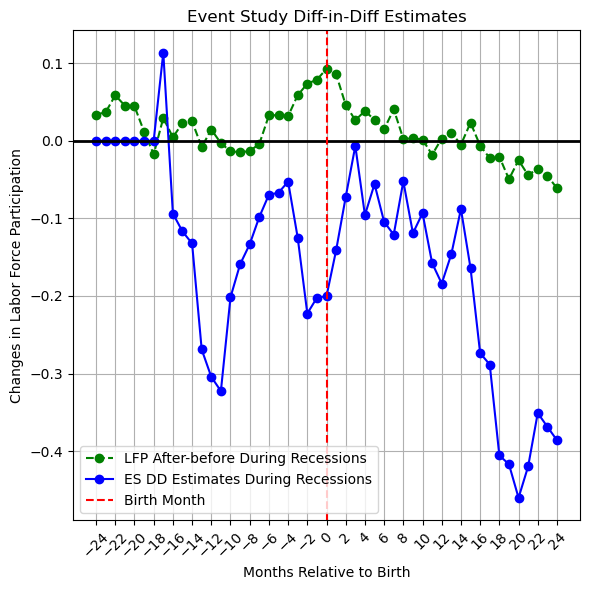

'The DiD results indicate that during recessions, the policy was less effective or even harmful for the treatment group compared to non-recession times or the control group. \nThis suggests that the policy’s ability to help women stay in the labor force might be limited in periods of economic downturn, \npossibly because the labor market conditions during recessions prevent women from fully benefiting from the paid leave.'

In [24]:
months = np.arange(-24, 25)  # From -24 to 24 months
plot_df = pd.DataFrame({
    'Month': list(range(-24, 25)),
    'Difference':results_df['Difference_Recession'].values,
    'With Recession': plot_df['With Recession'].values
})

# Plotting
plt.figure(figsize=(6, 6))


# Plot Difference
plt.plot(results_df['Month'], results_df['Difference_Recession'], label='LFP After-before During Recessions', color='green', linestyle='--',marker='o') #this is the difference between post and pre policy during recession birth years
plt.plot(plot_df['Month'], plot_df['With Recession'], label='ES DD Estimates During Recessions', color='blue', marker='o') #this is ES DD estimates with recession


# Adding labels and title

plt.axhline(0, color='black', linestyle='-', linewidth=2)  # Add a horizontal line at y=0
plt.title('Event Study Diff-in-Diff Estimates')
plt.xlabel('Months Relative to Birth')
plt.ylabel('Changes in Labor Force Participation')
plt.xticks(np.arange(-24, 25, 2), rotation=45)
plt.axvline(0, color='red', linestyle='--', label='Birth Month')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

'''The policy's impact may no longer be homogeneous, causing the patterns to diverge.
Including recession likely changes how different subgroups respond to the policy
It also highlights that the basic before-after comparison may mask important underlying dynamics (e.g., the influence of the recession on policy impact). '''
'''The DiD results indicate that during recessions, the policy was less effective or even harmful for the treatment group compared to non-recession times or the control group. 
This suggests that the policy’s ability to help women stay in the labor force might be limited in periods of economic downturn, 
possibly because the labor market conditions during recessions prevent women from fully benefiting from the paid leave.'''

#green line is the original pattern with recession post-pre policy

In [25]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you've already created X and y as specified before.
# Convert column names to strings
X.columns = X.columns.astype(str)

# Standardize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge regression regularization values
lambdas = 10**np.linspace(8, -2, 100) / y.std()


In [26]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    soln_array = skl.ElasticNet.path(X_scaled, y, l1_ratio=0., alphas=lambdas)[1]
    print(soln_array.shape)

ValueError: Input contains NaN.

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()

# Compute the ridge path
coefs = []
for alpha in lambdas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Verify the shape of coefficients
print(coefs.shape)  # Should match (100, number of features)

# Ensure that the number of columns matches
assert coefs.shape[1] == len(X.columns), "Mismatch between coefficients and feature columns"


In [ ]:
print(soln_array.shape) 
print(len(X.columns)) 
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

In [ ]:
soln_path.columns = soln_path.columns.str.lstrip('_')
path_fig, ax = plt.subplots(figsize=(8, 8))

# Plot each column with a label
lines = []
for column in soln_path.columns:
    line, = ax.plot(soln_path.index, soln_path[column], label=column)
    lines.append(line)

# Set axis labels
ax.set_xlabel('$-\log_{10}(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)

# No legend as too many variables, rather we focus on the plot pattern

# Set title
plt.title('Ridge Regression Path', fontsize=20)

# Show plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

lambdas = 10**np.linspace(8, -2, 100) / y.std()

# Prepare lists to hold mean and standard deviation of MSE
mean_mse = []
std_mse = []

# Cross-validated MSE for each lambda
for lambda_ in lambdas:
    ridge_model = Ridge(alpha=lambda_)
    mse_scores = cross_val_score(ridge_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    mean_mse.append(-mse_scores.mean())
    std_mse.append(mse_scores.std())
    
    
optimal_index = np.argmin(mean_mse)
optimal_lambda = lambdas[optimal_index]

# Fit the Ridge model with the optimal lambda
ridge_model = Ridge(alpha=optimal_lambda)
ridge_model.fit(X_scaled, y)

# Access the coefficients
coefficients = ridge_model.coef_

# Plotting the results

ridge_fig, ax = plt.subplots(figsize=(8, 8))
ax.errorbar(-np.log10(lambdas),
            mean_mse,
            yerr=std_mse / np.sqrt(5),  # Adjusting for the number of folds
            fmt='o', capsize=5, label='Cross-validated MSE')

# Set limits and labels
ax.set_xlabel('$-\log_{10}(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_title('Cross-Validated MSE vs. $-\log_{10}(\lambda)$', fontsize=20)
ax.legend()

# Show the plot
plt.show()

In [ ]:

# Print the features whose coefficients went to zero at any point
zero_coefficients = soln_path[(soln_path == 0)] # Check for any zero values in each column

print("Features that went to zero:")
print(zero_coefficients.columns[zero_coefficients.ne(0).any()].tolist())
zeroed_features = zero_coefficients.columns[zero_coefficients.ne(0).any()].tolist()
# List the features that have at least one zero coefficient
print(f"Number of features that went to zero: {len(zeroed_features)}")  # Count of features that went to zero

# Count total number of features
total_features = X.shape[1]  # Total number of features in the original dataset
print(f"Total number of features: {total_features}")

non_zero_coefficients = soln_path[(soln_path != 0)]  # Check for any non-zero values in each column

# Print the features whose coefficients did not go to zero
non_zeroed_features = non_zero_coefficients.columns[non_zero_coefficients.ne(0).all()].tolist()
print("Features that did not go to zero:")
print(non_zeroed_features)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel

# Create the DAG
dag = CausalGraphicalModel(
    nodes=['LFP', 'Birth', 'post_policy', 'State', 'Age', 'BirthXpost_policy', 'ref_month', 'Recession'],
    edges=[
        ('Birth', 'LFP'),            # Direct effect of Birth on LFP
        ('post_policy', 'LFP'),      # Direct effect of post_policy on LFP
        ('BirthXpost_policy', 'LFP'), # Interaction effect
        ('State', 'Birth'),           # State as a confounder
        ('State', 'LFP'),             # State affecting LFP
        ('Age', 'Birth'),             # Age affecting decision to give birth
        ('Age', 'LFP'),               # Age affecting LFP
        ('Recession', 'LFP'),         # Recession affecting LFP
        ('ref_month', 'Birth'),       # ref_month may affect Birth
        ('ref_month', 'LFP')          # ref_month may also affect LFP
    ])

def plot_dag(G, title):
    pos = nx.spring_layout(G, k=0.5, iterations=50)  # Layout for the nodes
    plt.figure(figsize=(10, 7))                       # Set the figure size
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, arrowsize=20, font_size=10)
    plt.title(title)                                   # Title of the plot
    plt.axis('off')                                    # Turn off the axis
    plt.show()                                         # Show the plot

# Plot the updated DAG
plot_dag(G, "DAG Representing Relationships in the DiD Model with Recession, Birth, and Policy Effects")




In [ ]:
# Backdoor paths from 'Birth' to 'LFP'
backdoor_paths = [
    "State -> Birth -> LFP",
    "Age -> Birth -> LFP",
    "ref_month -> Birth -> LFP",
    "Recession -> Birth -> LFP"
]

print("Backdoor Paths from 'Birth' to 'LFP':")
for path in backdoor_paths:
    print(f"- {path}")

In [ ]:
from causalgraphicalmodels import CausalGraphicalModel
from dowhy import CausalModel
import graphviz
from IPython.display import display, Image

# Define your variables
selected_confounders = ['state', 'age_group', 'recession_birth', 'ref_month']  # Confounders
treatment_vars = ['post_policy'] # Treatment variables
outcome_var = 'rm_lfp'  # Outcome variable

# Initialize the updated DOT string for the graph
updated_dot_string = """
strict digraph {
"""

# Add confounders to the graph
for confounder in selected_confounders:
    updated_dot_string += f'"{confounder}" [label="{confounder}"];\
'
    for var in treatment_vars:
        updated_dot_string += f'"{confounder}" -> "{var}";\
'
    updated_dot_string += f'"{confounder}" -> "{outcome_var}";\
'

# Add treatment variables to the graph
for var in treatment_vars:
    updated_dot_string += f'"{var}" [label="Treatment ({var})"];\
'
    updated_dot_string += f'"{var}" -> "{outcome_var}";\
'

# Add the outcome
updated_dot_string += f'"{outcome_var}" [label="Outcome ({outcome_var})"];\
'

# Close the graph
updated_dot_string += "}"

# Print the graph definition
print(updated_dot_string)

# Create the Causal Model
model = CausalModel(
    data=df,
    treatment='post_policy',  # Specify a single treatment variable here
    outcome=outcome_var,      # Specify the outcome variable
    graph=updated_dot_string   # Use the graph defined above
)

# View the model
model.view_model()

# Identify the effect
estimand = model.identify_effect()
print(estimand)



In [ ]:
# Clean NaN values consistently across treatment, outcome, and confounders
df_cleaned = df.dropna(subset=['post_policy', 'rm_lfp'] + selected_confounders)

# Check the dimensions of the cleaned data
print("Shape of cleaned treatment variables:")
print(df_cleaned[treatment_vars].shape)

print("Shape of cleaned outcome variable:")
print(df_cleaned[outcome_var].shape)

print("Shape of cleaned selected confounders:")
print(df_cleaned[selected_confounders].shape)

# Now, proceed to re-run the estimation
try:
    estimate = model.estimate_effect(
        identified_estimand=estimand,
        method_name='backdoor.econml.dml.DML',
        method_params={
            'init_params': {
                'model_y': GradientBoostingRegressor(),
                'model_t': GradientBoostingRegressor(),
                'model_final': LassoCV(fit_intercept=False),
            },
            'fit_params': {}
        }
    )

    print(f'Estimate of causal effect (DML): {estimate.value}')

except AssertionError as e:
    print(f"Error occurred: {e}")


In [ ]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)

In [ ]:
print(random_cause) #our model is likely well-specified, as it indicates that the causal relationship you identified is not sensitive to the inclusion of this random common cause.